In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage import transform as tf

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
import healpy as hp

### Fetching tile

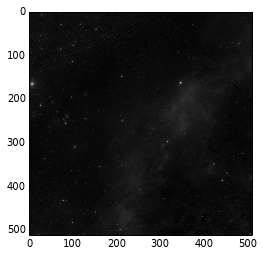

In [30]:
hdu_list = fits.open('https://rawgithub.com/hipspy/hips-extra/master/datasets/samples/DSS2Red/Norder3/Dir0/Npix335.fits')
tile_wcs = WCS(hdu_list[0].header)
tile = hdu_list[0].data.astype('float')
plt.imshow(tile, cmap='gray')
plt.show()

### Creating a WCS object

In [31]:
w = WCS(naxis=2)

skydir = SkyCoord(0, 0, unit='deg', frame='galactic')

w.wcs.ctype[0] = 'GLON-{}'.format('AIT')
w.wcs.ctype[1] = 'GLAT-{}'.format('AIT')
w.wcs.crval[0] = skydir.galactic.l.deg
w.wcs.crval[1] = skydir.galactic.b.deg

w.wcs.crpix[0] = 1000
w.wcs.crpix[1] = 500

w.wcs.cdelt[0] = -0.01
w.wcs.cdelt[1] = 0.01

w = WCS(w.to_header())

shape = (1000, 2000)
all_sky_wcs = w

### Function definition for computing HiPS tile corners

In [39]:
def compute_corners(order, ipix):
    nside = hp.order2nside(order)
    coords = hp.boundaries(nside, ipix, nest=True)
    theta, phi = hp.vec2ang(np.transpose(coords), lonlat=False)
    radec = SkyCoord(ra=phi, dec=np.pi/2 - theta, unit='radian', frame='icrs')
    
    result = []
    for i in range(len(radec.ra.deg)):
        result.append([radec.ra.deg[i], radec.dec.deg[i]])
    return result

def compute_corners_skycoord(order, ipix):
    nside = hp.order2nside(order)
    coords = hp.boundaries(nside, ipix, nest=True)
    theta, phi = hp.vec2ang(np.transpose(coords), lonlat=False)
    radec = SkyCoord(ra=phi, dec=np.pi/2 - theta, unit='radian', frame='icrs')
    galactic = radec.galactic
    pixels = galactic.to_pixel(all_sky_wcs)
    result = []
    for i in range(len(pixels[0])):
        result.append([pixels[0][i], pixels[1][i]])
    return result

### Function definition for drawing a  HiPS tile

In [37]:
from skimage import transform as tf
def draw_tile(warped, corners, out_shape, wcs):
    src = all_sky_wcs.wcs_world2pix(corners, 0)
    print('Source : ', src)
    dst = np.array([[511, 0], [511, 511], [0, 511], [0, 0]])

    tform3 = tf.ProjectiveTransform()
    tform3.estimate(src, dst)
    return warped + tf.warp(tile, tform3, output_shape=out_shape)

Corners:  [[0.0, 9.5940682268604593], [354.375, 4.78019184719916], [0.0, 0.0], [5.625, 4.78019184719916]]
Source :  [[  999.          1457.2863541 ]
 [ 1559.97491994   977.02428079]
 [  999.           499.        ]
 [  438.02508006   977.02428079]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


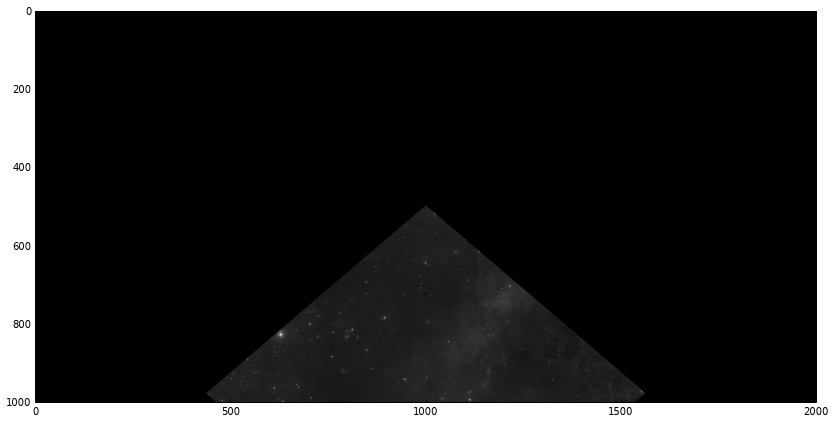

In [41]:
from astropy.visualization.wcsaxes import WCSAxes
warped = np.zeros((1000, 2000)) # the output image size

indices = [304]#, 335, 336, 368, 399, 400, 432, 463]
for index in indices:
    corners = compute_corners(3, index)
    print('Corners: ', corners)
    warped = draw_tile(warped, corners, warped.shape, wcs1)
print(warped)
fig, ax = plt.subplots(nrows=1, figsize=(14, 14))

ax.imshow(warped, origin='upper', cmap=plt.cm.gray)


Corners:  [[-5706.1581939615162, -4853.9466188390952], [-4779.6591222458528, -4966.1093132163978], [-4203.2612236722425, -5593.6841464224271], [-5237.6912677957507, -5457.2147650904881]]
Source :  [[ 22671.90583701  -2039.1341692 ]
 [  4163.44254114   7668.45989225]
 [ 20142.60857537   3236.16281082]
 [ -7331.96416651  -6046.06806079]]


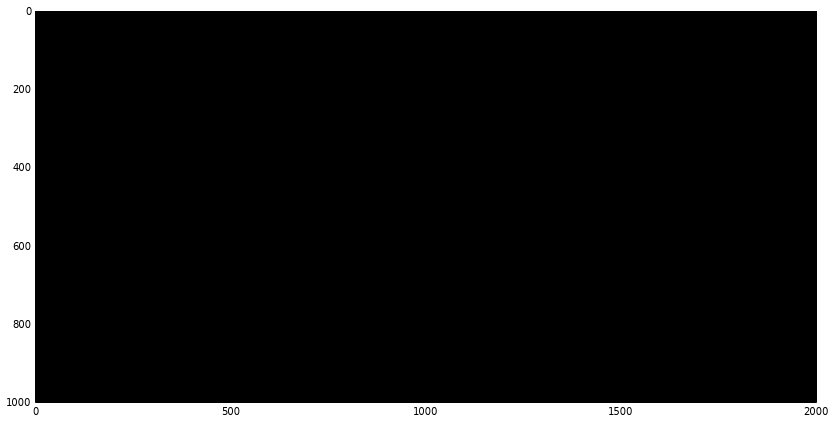

In [42]:
from astropy.visualization.wcsaxes import WCSAxes
warped = np.zeros((1000, 2000)) # the output image size

indices = [304]#, 335, 336, 368, 399, 400, 432, 463]
for index in indices:
    corners = compute_corners_skycoord(3, index)
    print('Corners: ', corners)
    warped = draw_tile(warped, corners, warped.shape, wcs1)
fig, ax = plt.subplots(nrows=1, figsize=(14, 14))

ax.imshow(warped, origin='upper', cmap=plt.cm.gray)
